In [14]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pkl
import numpy.random as nrand
import scipy.stats as stats

In [15]:
rcParams_dict = {
    'font.size': 15,
    'pdf.fonttype':42,
    'font.family':'Arial',
    'mathtext.fontset':'custom',
    'mathtext.default': 'regular',
    'mathtext.it': 'Arial:italic',
    'mathtext.it': 'Arial:italic',
}
mpl.rcParams.update(rcParams_dict)

In [3]:
## uncomment if want to regenerate the .pkl file.

# AF_dict = {}

# for N_gen in range(80000,110001,10):
#     print(N_gen,flush=True,end='\r')
    
#     tmp_df = pd.read_table(
#         f'./data/Simulation_log/env20_AF_dynamics/env20_{N_gen}.txt',  # replace the file name here for appropriate model.
#         header = None,
#         delim_whitespace = True
#     )

#     tmp_df = tmp_df[[4,7,10,11]].rename({4:'ID',7:'s',10:'SG',11:'AF'},axis=1)
    
#     for i, row in tmp_df.iterrows():
#         ID = row['ID']
#         if (ID in AF_dict) and (row['AF'] < 20000):
#             AF_dict[ID]['AF'].append(row['AF'])
#             AF_dict[ID]['s'].append(row['s'])
#             AF_dict[ID]['EG'] = N_gen
#         elif row['AF'] < 20000:
#             AF_dict[ID]={'AF':[row['AF']],'SG':row['SG'],'EG':N_gen,'s':[row['s']]}

# with open('./data/Simulation_log/env20_AF_dynamics_test.pkl','wb') as f:
#     pkl.dump(AF_dict,f)

In [36]:
# In parenthesis (random seed, ids of strongly non-neutral mutations, model AF_dict)
model_dict = {
    'Neutral_AF_dynamics': [13, []], # for Neutral model (Fig. 3A)
    'Adaptrack_standard_AF_dynamics': [22, [27842930.0,31294446.0]], # for Adaptrack standard model (Fig. 3B)
    'Adaptrack_env20_AF_dynamics': [30, [26427231.0,33683783.0]] # for Adaptrack_env20 model (Fig. 3C)
}
model_list = list(model_dict.keys())

for i, model in enumerate(model_list):
    with open(f'./data/Simulation_log/{model}.pkl','rb') as f:
        AF_dict = pkl.load(f)
    model_dict[model].append(AF_dict)

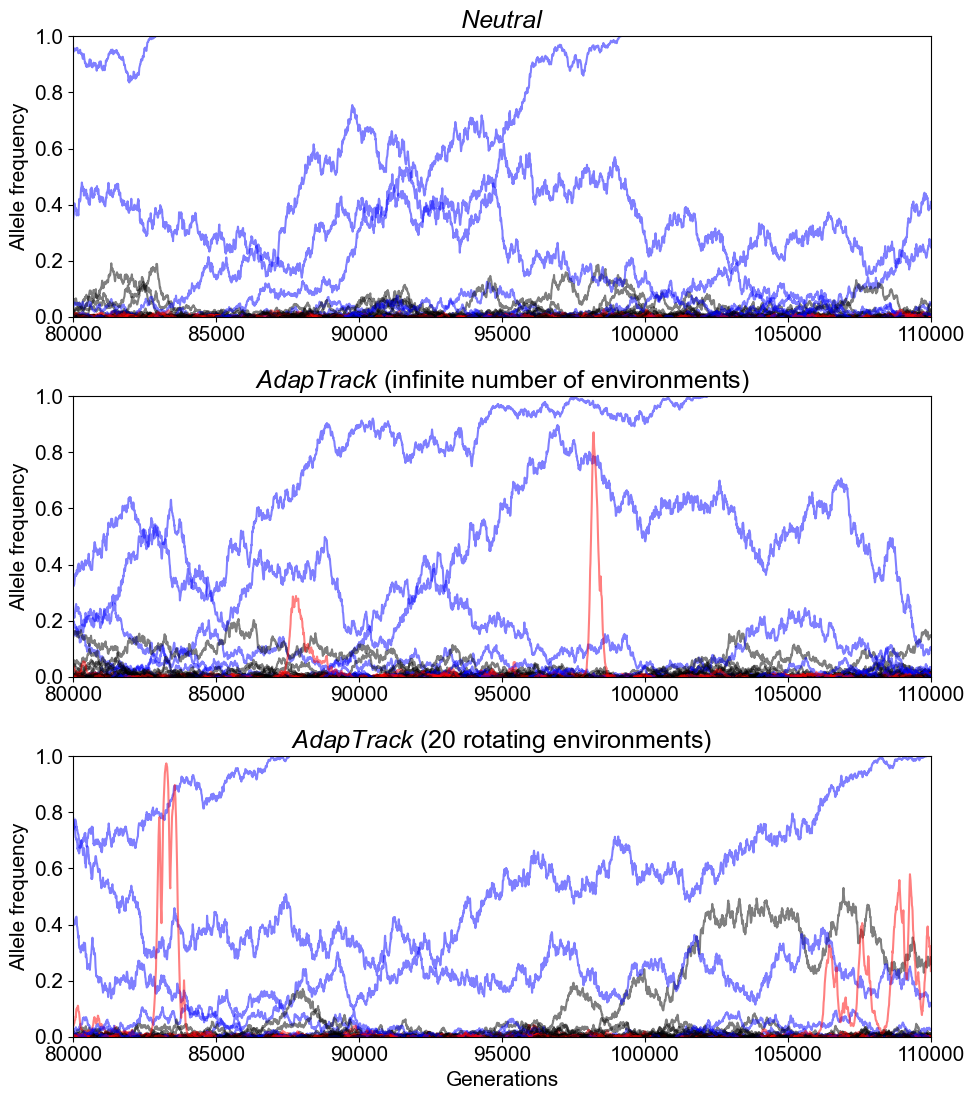

In [59]:
title_list = ['$\mathit{Neutral}$','$\mathit{AdapTrack}$ (infinite number of environments)','$\mathit{AdapTrack}$ (20 rotating environments)']

Ne = 10000

fig,axes = plt.subplots(3, 1, figsize=[10, 11.25], facecolor='w')

for i, model in enumerate(model_list):
    ax = axes[i]    
    seed, add_ids, AF_dict = model_dict[model]
    id_list = list(AF_dict.keys())
    
    nrand.seed(seed)
    id_sub_list = nrand.choice(id_list,50000,replace=False)
    id_sub_list = np.append(id_sub_list, add_ids)
    
    for _id in id_sub_list:
        item = AF_dict[_id]
        
        if item['EG'] - item['SG'] < 200:
            continue
        if np.abs(item['s']).mean() <= 0:
            c = 'b'; a=0.5
        elif np.abs(item['s']).mean() < 0.005:
            c = 'k'; a = 0.5
        else:
            c = 'r'; a=0.5;
            
        ax.plot(
            range(max(80000,int(item['SG'])),int(item['EG'])+1,10),item['AF'],
            color = c,
            alpha = a
        )
    
    ax.set_ylim(0,20000)
    ax.set_xlim(80000,110000)
    ax.set_yticks(np.linspace(0,20000,6))
    ax.set_yticklabels(np.linspace(0,10,6)/10)
    ax.set_ylabel('Allele frequency')
    if i == len(model_list) - 1:
        ax.set_xlabel('Generations')
    ax.set_title(title_list[i])
plt.tight_layout()

#plt.savefig('./Figures/Fig3ABC.pdf')

In [57]:
sim_df_dict = {} 
for version in ['Neutral','Adaptrack_standard','Adaptrack_env20']:
    sim_df_dict[version] = pd.read_csv(f'./data/Simulation_log/sim_summary_{version}.txt')

env_change_dict = {}
for version in ['Adaptrack_standard','Adaptrack_env20']:
    env_change_list = []
    p_env = -1
    for i,row in sim_df_dict[version].iterrows():
        if row['env_idx'] != p_env:
            env_change_list.append(row['generation'])
            p_env = row['env_idx']
    env_change_dict[version] = env_change_list

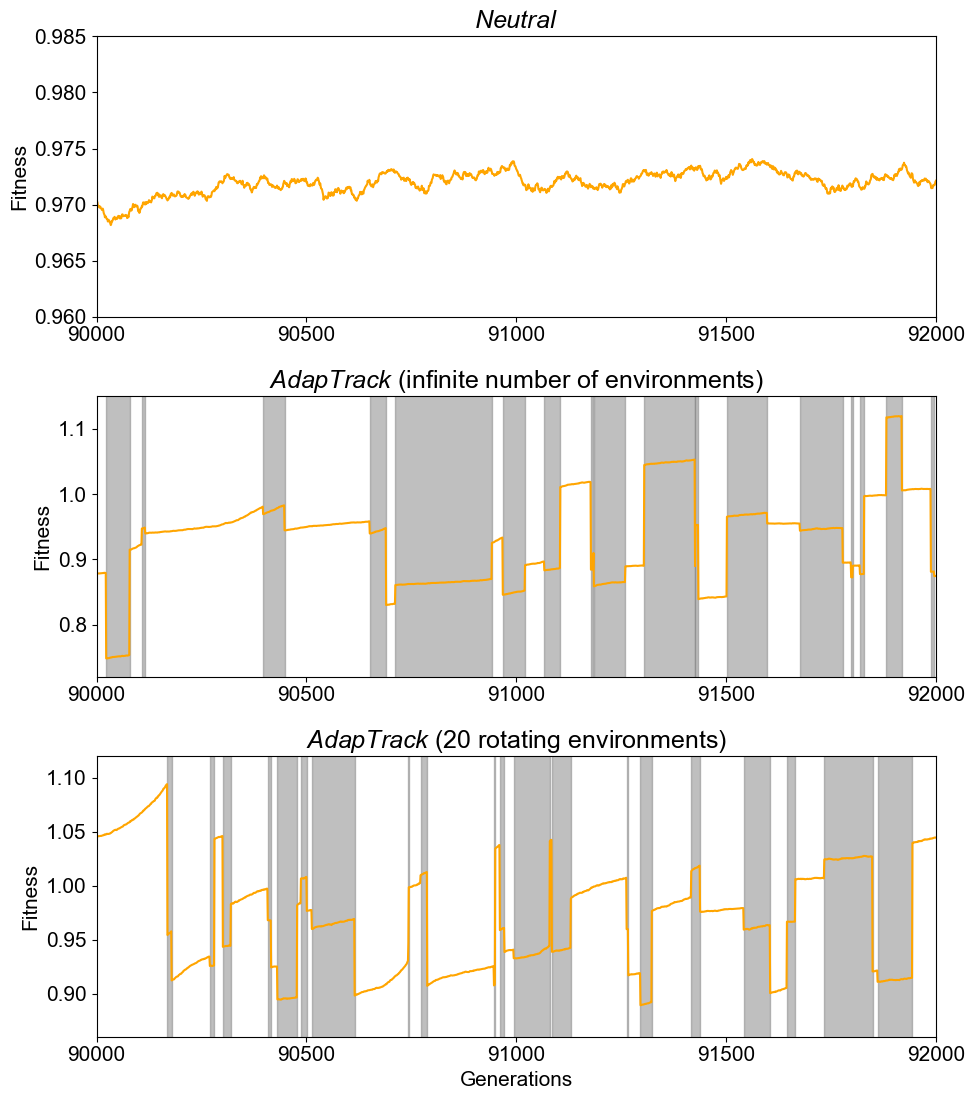

In [58]:
color_list = ['orange', 'orange', 'orange']
title_list = ['$\mathit{Neutral}$', '$\mathit{AdapTrack}$ (infinite number of environments)', '$\mathit{AdapTrack}$ (20 rotating environments)']
fig,axes = plt.subplots(3,1,figsize=[10,11.25],facecolor='w')
for i, version in enumerate(['Neutral', 'Adaptrack_standard', 'Adaptrack_env20']):
    ax = axes[i]
    ax.plot(sim_df_dict[version]['Mean_fitness'],color=color_list[i])
    # draw grey shades
    if version != 'Neutral':
        Gen_pointer = -1
        if version == 'Adaptrack_pop10000':
            Gen_pointer = 90000
        for Gen_idx in env_change_dict[version]:
            if Gen_idx > 90000:
                if Gen_pointer == -1:
                    Gen_pointer = Gen_idx
                else:
                    ax.fill_between([Gen_pointer-80000,Gen_idx-80000], 0, 1.5, alpha=0.5,color='grey')
                    Gen_pointer = -1
            elif Gen_idx > 92000:
                break
                    
    ax.set_xlim(10000,12000)
    ax.set_xticks(range(10000,12001,500))
    ax.set_xticklabels(range(90000,92001,500))
    if version == 'Neutral':
        ax.set_ylim(0.96,0.985)
    elif version == 'Adaptrack_standard':
        ax.set_ylim(0.72,1.15)
    elif version == 'Adaptrack_env20':
        ax.set_ylim(0.86,1.12)
    ax.set_ylabel('Fitness')
    if i == 2:
        ax.set_xlabel('Generations')
    #ax.legend(loc='upper right')
    ax.set_title(title_list[i])
plt.tight_layout()
#plt.savefig('./Figures/Fig3DEF.pdf')